## Mid-level modularity: Implementing your own module

The library of influence functions, attribute initializers, or agent selectors is not exhaustive. defSim aims to enable users to build upon and extend the body of knowledge in the social influence modeling literature. Variations of models with a mid-level degree of modularity do exactly this. By writing one’s own implementationof a module in the defSim framework, the user can go beyond the default, while keeping models aligned with the literature and preserving the efficiency and scalability benefits of using the framework. In the example given in this notebook, we demonstrate how to replace the default attribute initializer and use it in an Experiment. For example, you might be interested in looking at the dynamics of opinion formation given different opinion distributions at the outset. The example experiment given here shows the effect of starting from a bimodal distribution versus a mixed distribution by implementing an attribute initializer and using it in an experiment. 

First, we import defSim, the AttributesInitializer class to create our own instance of this Abstract Base Class (ABC), and the method to set a categorical attribute. We also import NumPy, which we use to draw random values from a beta distribution. Second, we write the attribute intializer to match the structure dictated by the AttributesInitializer ABC. It is important to make sure that the class contains the same methods as the ABC, and that these methods contain the same arguments. All arguments that are unique to this method can be passed to the initializer through the key-worded arguments dictionary (kwargs). In this case, we give all the nodes an attribute ’sex’ and asssign one of ’female’ or ’male’ as its value. Based on this categorical attribute, we then draw an opinion from a beta distribution for every opinion feature. The beta distributions for the two types of agents have a different peak, resulting in a bimodal opinion distribution overall. Finally, we initialize and run an experiment, passing our new initializer to the ’attribute_initializer’ keyword. Note that we exclude the variable ’sex’ from the set of variables used for calculating dissimilarity (the ’exclude’ argument to the instance of the attribute initializer on line 22) and from the set of variables that can be influenced (on line 27).

We run the model twice, once with a bimodal opinion distribution and once with a mixed distribution, and plot the opinion distribution on the outset and the opinion trajectories of those two runs. Unsurprisingly, the opinion distribution on the outset (Figure 1 and 3) affects whether the population splits up into two groups, or whether they find consensus on the single opinion dimension (as shown in Figure 2 and 4).

For more information on writing a new module implementation, see the [GitHub wiki](https://github.com/defSim/defSim/wiki). 

In [1]:
import defSim as ds
import numpy as np
from defSim import EuclideanDistance   # imported to create instance with excluded agent attribute
import matplotlib.pyplot as plt
import networkx as nx

### A new Attribute Initializer

In [2]:
class MyAttributeInitializer(ds.AttributesInitializer):
    """
    This attribute initializer creates a group attribute (sex) and assigns one of two values (female / male) to an agent
    with equal probability. Thereafter, the values for the `num_features' desired features is drawn from a beta
    distribution. Parameters of the beta distribution are inverted for the two groups.
    """
    
    def __init__(self, beta_a=1, beta_b=1, seed=None):
        self.beta_a = beta_a
        self.beta_b = beta_b
        self.seed = seed
    
    def initialize_attributes(self, network, **kwargs):
        np.random.seed(self.seed)
        ds.set_categorical_attribute(network, 'sex', ["female", "male"])
        for j in range(kwargs.get('num_features', 1)):
            for i in network.nodes():
                if network.nodes[i]['sex'] == "female":
                    network.nodes[i]['f{:02d}'.format(j+1)] = np.random.beta(self.beta_a, self.beta_b)
                else:
                    network.nodes[i]['f{:02d}'.format(j+1)] = np.random.beta(self.beta_b, self.beta_a)

### A run with bimodal opinion distribution

The first run initializes the model with a bimodal opinion distribution. The opinions of members from the two groups are drawn from a beta distribution with $\alpha=2.5$ and $\beta=5$, and the inverse $\alpha=5$ and $\beta=2.5$

In [3]:
my_simulation = ds.Simulation(seed=3141,
                              attributes_initializer=MyAttributeInitializer(beta_a=2.5, beta_b=5, seed=3141),
                              dissimilarity_measure=EuclideanDistance(exclude=["sex"]),
                              topology="complete_graph",
                              parameter_dict={"n": 80,
                                              "confidence_level": 0.25,
                                              "convergence_rate": 0.25},
                              #communication_regime='one-to-many',
                              influenceable_attributes=["f01"],
                              influence_function="bounded_confidence",
                              tickwise=["f01"],
                              output_realizations=["Graph"],
                              max_iterations=5000)

results_bimodal = my_simulation.run_simulation()

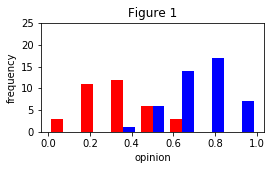

In [6]:
G = results_bimodal.loc[0, 'Graph']
sexes = [v for k, v in nx.get_node_attributes(G, 'sex').items()]
x = [results_bimodal['Tickwise_f01'][0][0], sexes]
x = list(map(list, zip(*x)))

#plt.hist(x, 10, density=False, histtype='bar')#, color=['red', 'blue'], label=['red', 'blue'])

plt.figure(figsize=[4, 2])

plt.tight_layout()

opinion_t0_male = [i for i, j in x if j == 'male']
opinion_t0_female = [i for i, j in x if j == 'female']

bins = np.linspace(0, 1, 8)

plt.hist([opinion_t0_female, opinion_t0_male], bins=bins, color=['r', 'b'])

plt.xlabel('opinion')
plt.ylabel('frequency')
plt.ylim(0, 25)
plt.title("Figure 1")

plt.show()

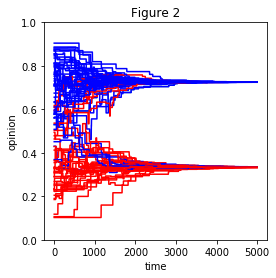

In [7]:
G = results_bimodal.loc[0, 'Graph']
sexes = [v for k, v in nx.get_node_attributes(G, 'sex').items()]

plt.figure(figsize=[4, 4])

colors = ['blue' if i == 'male' else 'red' for i in sexes]

opinions = np.array(results_bimodal['Tickwise_f01'][0]).transpose()
plt.plot(opinions[1])
for i in range(len(opinions)):
    plt.plot(opinions[i], color = colors[i])
    
plt.ylabel('opinion')
plt.xlabel('time')
plt.ylim(0, 1)
plt.title("Figure 2")

plt.show()

### A run with a mixed opinion distribution

In this run we initialize the model with a mixed opinion distribution. The opinions of members from the two groups are drawn from a beta distribution with $\alpha=2.5$ and $\beta=3$, and the inverse $\alpha=3$ and $\beta=2.5$. Thus, the two groups have a small bias towards opposite ends of the opinion scale, but the distributions largely overlap.

In [8]:
#my_simulation.attributes_initializer = MyAttributeInitializer(beta_a=2, beta_b=5, seed=31415)

#results_mixed = my_simulation.run_simulation()

my_simulation = ds.Simulation(seed=3141,
                              attributes_initializer=MyAttributeInitializer(beta_a=2.5, beta_b=3, seed=3141),
                              dissimilarity_measure=EuclideanDistance(exclude=["sex"]),
                              topology="complete_graph",
                              parameter_dict={"n": 80,
                                              "confidence_level": 0.25,
                                              "convergence_rate": 0.25},
                              #communication_regime='one-to-many',
                              influenceable_attributes=["f01"],
                              influence_function="bounded_confidence",
                              tickwise=["f01"],
                              output_realizations=["Graph"],
                              max_iterations=5000)

results_mixed = my_simulation.run_simulation()

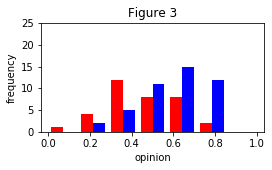

In [10]:
G = results_mixed.loc[0, 'Graph']
sexes = [v for k, v in nx.get_node_attributes(G, 'sex').items()]
x = [results_mixed['Tickwise_f01'][0][0], sexes]
x = list(map(list, zip(*x)))

#plt.hist(x, 10, density=False, histtype='bar')#, color=['red', 'blue'], label=['red', 'blue'])

plt.figure(figsize=[4, 2])

opinion_t0_male = [i for i, j in x if j == 'male']
opinion_t0_female = [i for i, j in x if j == 'female']

bins = np.linspace(0, 1, 8)

plt.hist([opinion_t0_female, opinion_t0_male], bins=bins, color=['r', 'b'])

plt.xlabel('opinion')
plt.ylabel('frequency')
plt.ylim(0, 25)
plt.title("Figure 3")

plt.show()

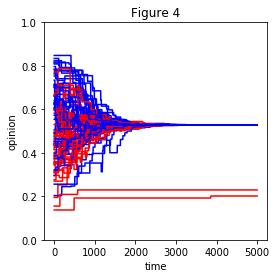

In [11]:
G = results_mixed.loc[0, 'Graph']
sexes = [v for k, v in nx.get_node_attributes(G, 'sex').items()]

plt.figure(figsize=[4, 4])

colors = ['blue' if i == 'male' else 'red' for i in sexes]

opinions = np.array(results_mixed['Tickwise_f01'][0]).transpose()
plt.plot(opinions[1])
for i in range(len(opinions)):
    plt.plot(opinions[i], color = colors[i])
    
plt.ylabel('opinion')
plt.xlabel('time')
plt.ylim(0, 1)
plt.title("Figure 4")

plt.show()